# OpenAI - Caribbean Challenge Competition 

### Train an Image Classifier from Aerial Photos with Transfer learning 

### Resnet-50 architecture



see: www.github.com/rockyxu66/Kaggles_Flowers_Classification_Keras

www.medium.com//three-models-for-kaggles-flowers-recognition-dataset...



In [ ]:
import numpy as np
import pandas as pd
import os
import gc

import tensorflow as tf
from tqdm import tqdm_notebook as tqdm

from pathlib import Path
import cv2

from matplotlib import pyplot as plt
import seaborn as sns

# from tensorflow.keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

# from helpers import plot_confusion_matrix, eval_metrics, plot_conv_weights

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from tensorflow.keras import backend as K

config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
sess = tf.Session(config=config)

### Load image data

In [ ]:
curr_path = Path('/home/ime/Documents/PycharmProjects/DrivenData/OpenAI')
data_path = curr_path / 'data/raw'
train_path = curr_path / 'data/pickle/'
img_path = curr_path / 'data/processed2/trainImages/'

categories = ['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [ ]:
# Load all image file names
fnames = []
for categ in categories:
    sub_folder = os.path.join(img_path, categ)
    file_names = os.listdir(sub_folder)
    full_path = [os.path.join(sub_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [ ]:
print('length of each class:', [len(f) for f in fnames])
print('total number of images:', sum([len(f) for f in fnames]))

length of each class: [1387, 7381, 668, 5241, 193]
total number of images: 14870


### Load images

In [ ]:
images = []
for names in fnames:
    one_class_img = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_class_img)


In [ ]:
print('no. of images for each class:', [len(f) for f in images])

no. of images for each class: [1387, 7381, 668, 5241, 193]


### Calculate minimal shape for all images

In [ ]:
for i, imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths= [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d, %d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))    
    print()
    print('%d, %d is the max shape for %s' % (np.max(widths), np.max(heights), categories[i]))    
    print('-'*10)

49, 67 is the min shape for concrete_cement

1199, 1186 is the max shape for concrete_cement
----------
14, 1 is the min shape for healthy_metal

1856, 1488 is the max shape for healthy_metal
----------
49, 51 is the min shape for incomplete

448, 438 is the max shape for incomplete
----------
42, 47 is the min shape for irregular_metal

856, 723 is the max shape for irregular_metal
----------
60, 37 is the min shape for other

664, 708 is the max shape for other
----------


### Show sample of images for all classes

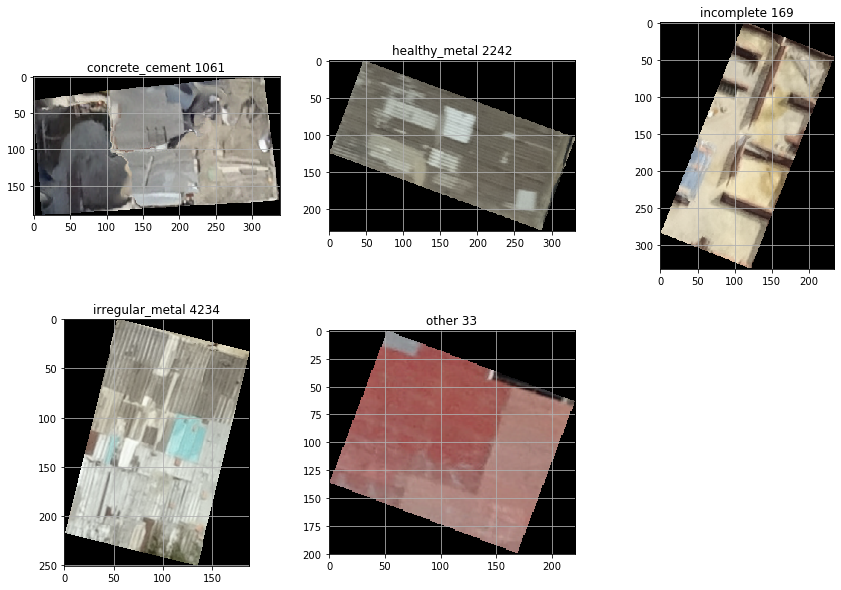

In [ ]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2, 3, i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(imgs[idx])
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

### Resize all images

In [ ]:
IMG_SIZE = 256

(212, 319, 3)
(256, 256, 3)


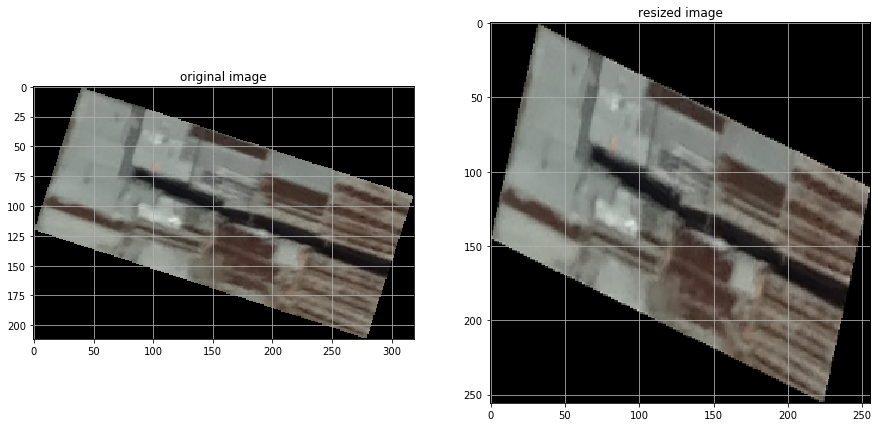

In [ ]:
# apply to single image
img = images[3][16]
print(img.shape)

img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
print(img_resized.shape)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('original image')
plt.grid('False')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('resized image')
plt.grid('False')
plt.imshow(img_resized)
plt.show()

In [ ]:
# apply to all images
images_resized = []
for i, imgs in enumerate(images):
    images_resized.append([cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC) for img in imgs])


### Download 

In [ ]:
# download label data

with open(train_path/'train_labels.pickle', 'rb') as f:
    train_labels_original  = pickle.load(f)

with open(train_path/'Y_train_verified.pickle', 'rb') as f:
    Y_train = pickle.load(f)

Y_train = [item for sublist in Y_train for item in sublist]
le = LabelEncoder()
Y_dummy_original = tf.keras.utils.to_categorical(le.fit_transform(Y_train), num_classes=5)

Y_dummy_original

### Split to train/val sets

In [ ]:
train_images = []
val_images = []
train_y = []
val_y = []
for imgs in images_resized:
    train, val = train_test_split(imgs, test_size=0.25)
    train_images.append(train)
    val_images.append(val)
 

### Create labels from scratch

In [ ]:
# A) kernel approach
len_train_images= [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images: ', np.sum(len_train_images))
train_categories = np.zeros(np.sum(len_train_images), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i

len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val images: ', np.sum(len_val_images))
val_categories = np.zeros(np.sum(len_val_images), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[1040, 5535, 501, 3930, 144]
sum of train images:  11150
[347, 1846, 167, 1311, 49]
sum of val images:  3720


### Convert images to arrays

In [ ]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)    
val_images = np.array(tmp_val_imgs)

In [ ]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)
# print('train labels2:', train_y.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')

train_labels = to_categorical(train_categories, len(categories))
val_labels = to_categorical(val_categories, len(categories))

print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)
# print('train labels2:', train_y.shape)


Before converting
train data: (11150, 256, 256, 3)
train labels: (11150,)

After converting
train data: (11150, 256, 256, 3)
train labels: (11150, 5)


### Shuffle dataset (both features and labels using same seed)

In [ ]:
SEED = 26
np.random.seed(SEED)
np.random.shuffle(train_data)

np.random.seed(SEED)
np.random.shuffle(train_labels)

np.random.seed(SEED)
np.random.shuffle(val_data)

np.random.seed(SEED)
np.random.shuffle(val_labels)

In [ ]:
train_data = train_data[:]
train_labels = train_labels[:]
val_data = val_data[:]
val_labels = val_labels[:]

print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (11150, 256, 256, 3)
shape of train labels: (11150, 5)
shape of val data: (3720, 256, 256, 3)
shape of val labels: (3720, 5)


### Master params

In [ ]:
# IMG_SIZE = 256
no_classes = 5
BATCH_SIZE = 32
EPOCHS = 30

In [ ]:
# download Resnet weights 
WEIGHTS_PATH = curr_path/'saved_models/ResNet_pretrained/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
str(WEIGHTS_PATH).endswith('.h5')

True

### Build Model

In [ ]:
# see: https://www.kaggle.com/cokastefan/keras-resnet-50

# base = tf.keras.applications.ResNet50(include_top=False, pooling='avg', weights=str(WEIGHTS_PATH))
# base.output

from tensorflow.keras.applications import ResNet50

def build_resnet_base():
    
    """ Build ResNet base model with Freezed params """  
    
    resnet = ResNet50(include_top=False, weights=WEIGHTS_PATH, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    output = resnet.layers[-1].output
    output = tf.keras.layers.Flatten()(output)
    model = tf.keras.models.Model(inputs=resnet.input, output=output)
    return model

resnet_base = build_resnet_base()

#Freeze weights
for layer in resnet_base.layers: 
    layer.trainable = False

#Print Model summary
resnet_base.summary()

##TODO: Turn the Sequential to Functional and crosscheck 
##TODO: Try with optimizers.RMSprop(lr=2e-5)
    
def build_resenet_seq():
    model = tf.keras.layers.Sequential()
    model.add(resnet_base)
    model.add(tf.keras.layers.Dense(1024, activation='relu', input_dim=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_resenet_func():
    x = resnet_base
    x = tf.keras.layers.Flatten()(x) 
    x = tf.keras.layers.Dense(1024, activation='relu', input_dim=(IMG_SIZE, IMG_SIZE, 3))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    out = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.models.Model(resnet_base.input, out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

resenet_seq = build_resenet_seq()
resenet_func = build_resenet_func()

#Print Models summary
resenet_seq.summary()
resenet_func.summary()

In [ ]:
from tensorflow.keras.applications import ResNet50

def build_model_resnet():
    
#     inp = tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    
    base = tf.keras.applications.ResNet50(include_top=False, pooling='avg', 
                                          weights=str(WEIGHTS_PATH), 
                                          input_shape=(IMG_SIZE,IMG_SIZE,3))
        
    # add custom layers
    x = base.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    #     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    #     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(0.5)(x)
    
    out = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base.input, outputs=out)
        
#     model.layers[0].trainable = False    
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [ ]:
# Set the first N layers to non-trainable 
N = 0  # change this munber !! 
for layer in model.layers[:N]:
    layer.trainable = False
    
# Freeze all base layers    
for layer in base.layers:
    layer.trainable = False    

In [ ]:
model = build_model_resnet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

#check trainable layers
layers_df = [(layer, layer.name, layer.trainable) for layer in model.layers]
layers_df = pd.DataFrame(layers_df, columns=['Layer Type', 'Layer Name', 'Trainable'])

layers_df

### Create Generators

In [ ]:
# train configuration: rescale, rotation, shift, shear/zoom range, horizontal flip
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# validation configuration: rescale only
val_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.4,
#     height_shift_range=0.4,
#     shear_range=0.2,
#     zoom_range=0.3,
#     horizontal_flip=True
)

# Flow images 
train_generator = train_datagen.flow(train_data, train_labels, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(val_data, val_labels, batch_size=BATCH_SIZE)

In [ ]:
# callbacks 
# 'model_res50_{epoch:02d}-{val_acc:.2f}.h5'
mdl_dir = '../saved_models/model2/ResNet50_1024_512-{val_loss:.3f}.h5'
# tb_dir = '../TB_logs/model2/'

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min') #min_delta=0.01
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_delta=0.0001)
mc = tf.keras.callbacks.ModelCheckpoint(filepath=mdl_dir, monitor='val_loss', save_best_only=True, mode='auto')
# tb = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, write_graph=True, update_freq='epoch')


## Train the model


#### Fit the model with generator

In [ ]:
hist = model.fit_generator(
    generator=train_generator,
    steps_per_epoch = np.ceil(len(train_data)/BATCH_SIZE),     # 349 step*BATCH_SIZE = num of images
    epochs=EPOCHS,
    validation_steps=np.ceil(len(val_data)/BATCH_SIZE),        # 117 step*BATCH_SIZE = num of images
    validation_data=val_generator,
    verbose=1
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
349/349 [==============================] - 3128s 9s/step - loss: 1.4109 - acc: 0.5975 - val_loss: 1.3016 - val_acc: 0.4962
Epoch 2/30
349/349 [==============================] - 3108s 9s/step - loss: 1.1138 - acc: 0.6320 - val_loss: 6.6523 - val_acc: 0.3548
Epoch 3/30
349/349 [==============================] - 3110s 9s/step - loss: 1.0331 - acc: 0.6417 - val_loss: 1.0975 - val_acc: 0.6567
Epoch 4/30
349/349 [==============================] - 3129s 9s/step - loss: 0.8457 - acc: 0.6823 - val_loss: 0.9072 - val_acc: 0.6301
Epoch 5/30
349/349 [==============================] - 3195s 9s/step - loss: 0.8000 - acc: 0.7008 - val_loss: 0.9041 - val_acc: 0.7005
Epoch 6/30
349/349 [==============================] - 3189s 9s/step - loss: 0.7642 - acc: 0.7187 - val_loss: 0.7968 - val_acc: 0.7048
Epoch 7/30
349/349 [==============================] - 3119s 9s/step - loss: 0.7663 - acc: 0.7152 - val_loss: 0.9514 - val_acc: 0.6817
Epoch 8/30
349

### Evaluate the model

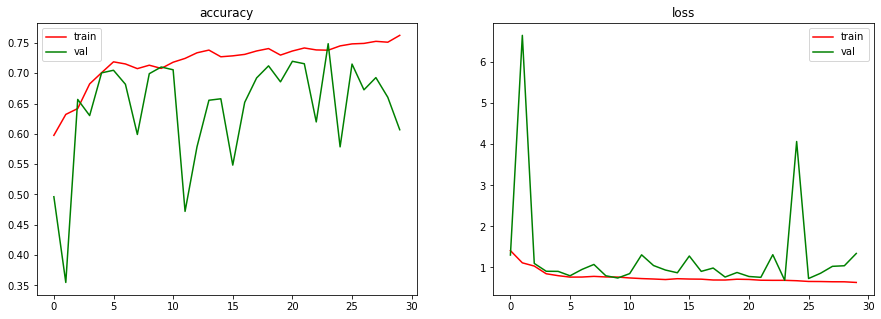

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'g')
plt.xticks()
plt.title('loss')
plt.legend(['train', 'val'], loc='best')    

plt.subplot(1,2,2)
plt.plot(hist.history['acc'], 'r')
plt.plot(hist.history['val_acc'], 'g')
plt.xticks()
plt.title('accuracy')
plt.legend(['train', 'val'], loc='best')            
plt.show()                

### Predict one Image

In [ ]:
def predict_one_image(img, model=model):
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    img = np.reshape(img, (1, IMG_SIZE, IMG_SIZE, 3))
    img = img/255.
    pred = model.predict(img)
    pred_class = np.argmax(pred)
    return pred_class, np.max(pred)    

healthy_metal 94%


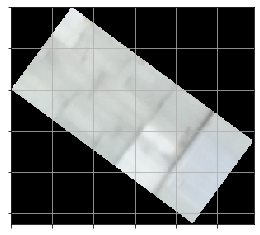

2362

In [ ]:
sample_img = cv2.imread(test_fnames[23])

pred, prob = predict_one_image(sample_img, model)
print('%s %d%%' % (categories[pred], round(prob,2)*100))
_, ax = plt.subplots(1)
plt.imshow(sample_img)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

del pred, prob
gc.collect()

### Predict on validation data

In [ ]:
def predict_val_data(val_data, model=model):
    val_input = np.reshape(val_data, (-1, IMG_SIZE, IMG_SIZE, 3))
    val_input = val_input/255.
    pred = model.predict(val_input)
    pred_class = np.argmax(pred)
    return pred_class, np.max(pred)  

def predict_val_data2(val_data, model=model):
    val_input = np.reshape(val_data, (-1, IMG_SIZE, IMG_SIZE, 3))
    val_input = val_input/255.
    pred = model.predict(val_input)
    pred_class = np.argmax(pred)
    return pred_class, pred

In [ ]:
def return_categ_name(label_arr):
    idx = np.where(label_arr == 1)
    return idx[0][0]

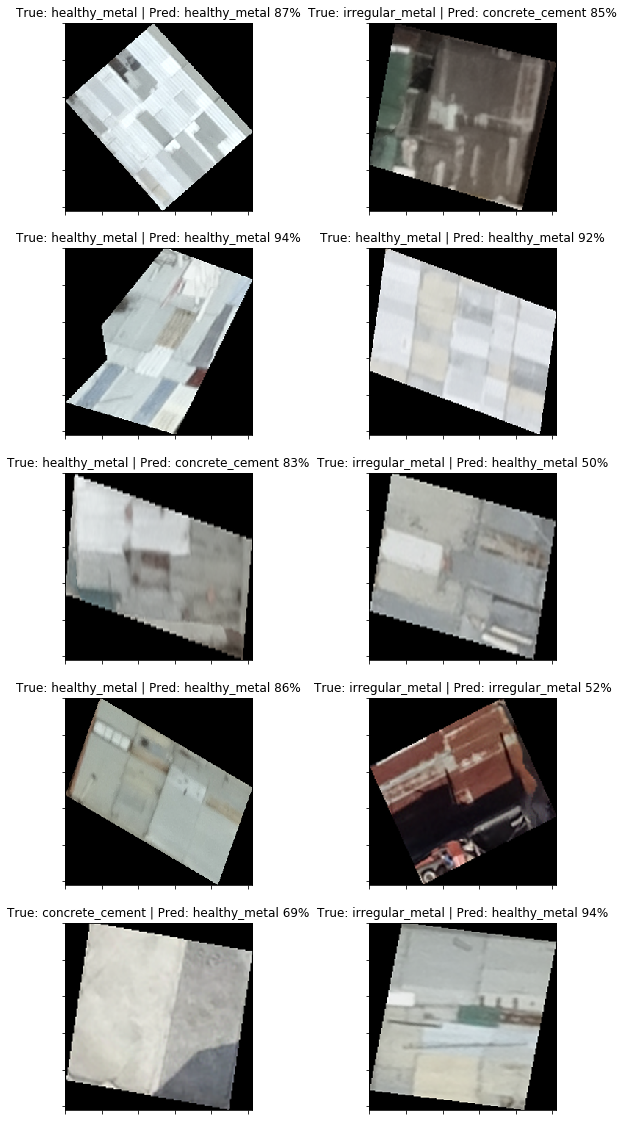

In [ ]:
plt.figure(figsize=(10,20))
for i in range(10):
    idx = np.random.randint(len(val_data))

    ax = plt.subplot(5, 2, i+1)
    plt.imshow(val_data.astype('uint8')[idx])
    category_idx = return_categ_name(val_labels[idx])

    pred, prob = predict_val_data(val_data[idx], model=model)
    
    plt.title('True: %s | Pred: %s %d%%' % (categories[category_idx], categories[pred], round(prob, 2)*100))
    plt.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.show()

In [ ]:
y_pred_class_val, y_pred_val =  predict_val_data2(val_data)

In [ ]:
# # Logloss score
# score_logloss = log_loss(val_data, np.argmax(y_pred_val))
# print('Score on val data:', score_logloss)
# np.argmax(y_pred_val)
# y_pred_val[0]
# val_data[0]

In [ ]:
# # save model (optional)
# model.save('Resnet50-1024-512_loss_xxx.h5')

### Predict on Test Images

#### Load test images filenames

In [ ]:
test_fnames = []
test_file_names = os.listdir(curr_path / 'data/processed2/testImages/')
test_fnames = [os.path.join(curr_path / 'data/processed2/testImages/', file_name) for file_name in test_file_names]

In [ ]:
test_fnames[:1], test_file_names[:1]

(['/home/ime/Documents/PycharmProjects/DrivenData/OpenAI/data/processed2/testImages/7a4d1972.png'],
 ['7a4d1972.png'])

In [ ]:
# load test Images
testImages = [cv2.imread(name) for name in test_fnames if (cv2.imread(name)) is not None]

len(testImages)

7325

In [ ]:
# check original sizes of test Images 
test_shapes = [img.shape for img in testImages]
test_widths= [shape[0] for shape in test_shapes]
test_heights = [shape[1] for shape in test_shapes]
print('%d, %d is the min shape for test set' % (np.min(test_widths), np.min(test_heights)))    
print('-'*40)
print('%d, %d is the max shape for test set' % (np.max(test_widths), np.max(test_heights))) 

#### Resize test images

In [ ]:
# check size before 
print('size before:', testImages[10].shape)

# resize test images
test_images_resized = []
test_images_resized = [cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC) for img in testImages]

# check size after
print('size after:', test_images_resized[10].shape)
print()
print('number of test images:', len(test_images_resized) )

In [ ]:
# rescale
# for i in range(len(testImages)):
#     testImages[i] = testImages[i].astype('float32')
#     testImages[i] = testImages[i]/255.0

# testImages = np.array(testImages)/255.
    
# testImages = np.array(testImages).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
# rescale 
test_images_resized = np.array(test_images_resized)/255.

# reshape to 4D
test_images_resized = np.array(test_images_resized).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# check new shape
test_images_resized[0].shape

### Inference on Test Images without generator

In [ ]:
# test predictions without generator

test_preds = model.predict(test_images_resized, batch_size=BATCH_SIZE)

In [ ]:
test_preds_class = np.argmax(test_preds, axis=1)
test_preds_class2 = [categories[test_preds_class[i]] for i in range(len(test_preds))] 

### Inference on Test images with generator

In [ ]:
# #Augmentation config for Test Images

# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow(test_images_resized3, batch_size=BATCH_SIZE)

# test_preds_gen = model.predict_generator(test_generator, verbose=1)

### Fine-tune Transfer learning ResNet-50 

In [ ]:
# # fine tune ResNet-50 + Dense

# resnet.trainable = True
# set_trainable = False
# for layer in resnet.layers:
#     if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False
        
# # print df        
# layers_df = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
# layers_df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

# layers_df

### Submission file

In [ ]:
mdl_name = 'ResNet50-1024-512'
out_name = 'Submission_'
out_name += mdl_name
out_name += '_epochs30'

sub_df = pd.read_csv(data_path/'submission_format.csv')

sub_df.iloc[:, 1:] = np.array(test_preds)

In [ ]:
sub_df.head()

In [ ]:
# export to csv 
sub_df.to_csv('%s.csv' % out_name, index=None)